# Data
### Projects

In [2]:
from collections import Counter
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [6]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (f"{len(projects)} projects")
print (json.dumps(projects[0], indent=2))

955 projects
{
  "id": 6,
  "created_on": "2020-02-20 06:43:18",
  "title": "Comparison between YOLO and RCNN on real world videos",
  "description": "Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.",
  "tag": "computer-vision"
}


In [9]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

955 projects


,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [12]:
# 1. remove projects with no tag
df = df[df.tag.notnull()]

In [13]:
# 2. Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

### Tags

In [17]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.json"
tags_dict = {}
for item in json.loads(urlopen(url).read()):
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")


4 tags


In [18]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag="computer-vision"):
    print (json.dumps(tags_dict[tag], indent=2))


interactive(children=(Dropdown(description='tag', options=('computer-vision', 'graph-learning', 'mlops', 'natu…

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

## Tag Distribution

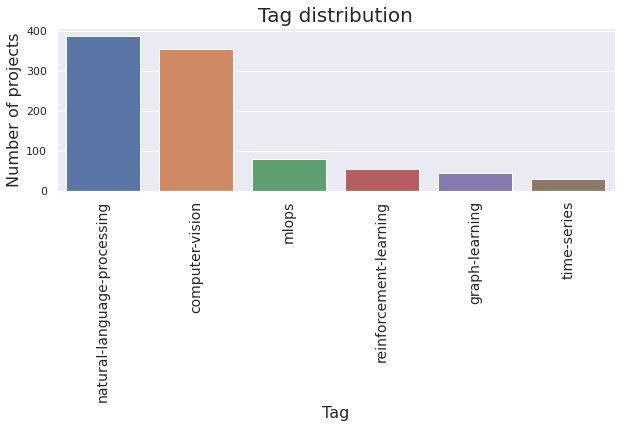

In [29]:
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

### Wordcloud

In [31]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
    plt.figure(figsize=(15, 5))
    subset = df[df.tag == tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    

interactive(children=(Dropdown(description='tag', options=('natural-language-processing', 'computer-vision', '…